In [1]:
from exp.expdata import LotkaVolterraExp
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

In [2]:
noise=0.5
noise = 0.1
dt_train = 5.555
# dt_train = 5.6
t1=97.
t1=46.
t1=1000.
# t1 = 300.
# t1=50.
expdata = LotkaVolterraExp(t0=0.,t1=t1,noise=noise, dt_train=dt_train,n_colloc=500, feature_names=['x','y'],seed=1234)

In [3]:
x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape

(181,)

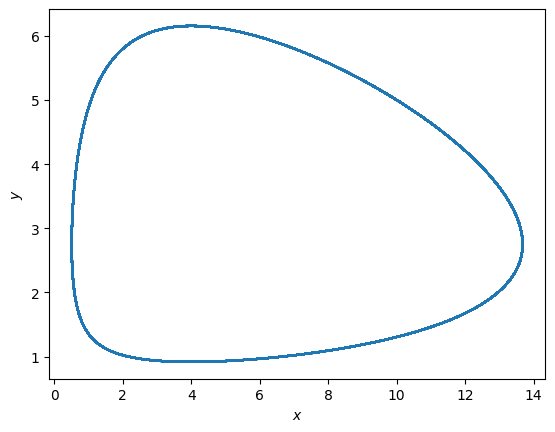

In [4]:
plt.plot(x_true[:,0], x_true[:,1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [5]:
t_train[-1]+dt_train, t_train

(Array(1005.455, dtype=float64),
 Array([  0.   ,   5.555,  11.11 ,  16.665,  22.22 ,  27.775,  33.33 ,
         38.885,  44.44 ,  49.995,  55.55 ,  61.105,  66.66 ,  72.215,
         77.77 ,  83.325,  88.88 ,  94.435,  99.99 , 105.545, 111.1  ,
        116.655, 122.21 , 127.765, 133.32 , 138.875, 144.43 , 149.985,
        155.54 , 161.095, 166.65 , 172.205, 177.76 , 183.315, 188.87 ,
        194.425, 199.98 , 205.535, 211.09 , 216.645, 222.2  , 227.755,
        233.31 , 238.865, 244.42 , 249.975, 255.53 , 261.085, 266.64 ,
        272.195, 277.75 , 283.305, 288.86 , 294.415, 299.97 , 305.525,
        311.08 , 316.635, 322.19 , 327.745, 333.3  , 338.855, 344.41 ,
        349.965, 355.52 , 361.075, 366.63 , 372.185, 377.74 , 383.295,
        388.85 , 394.405, 399.96 , 405.515, 411.07 , 416.625, 422.18 ,
        427.735, 433.29 , 438.845, 444.4  , 449.955, 455.51 , 461.065,
        466.62 , 472.175, 477.73 , 483.285, 488.84 , 494.395, 499.95 ,
        505.505, 511.06 , 516.615, 522.17 , 

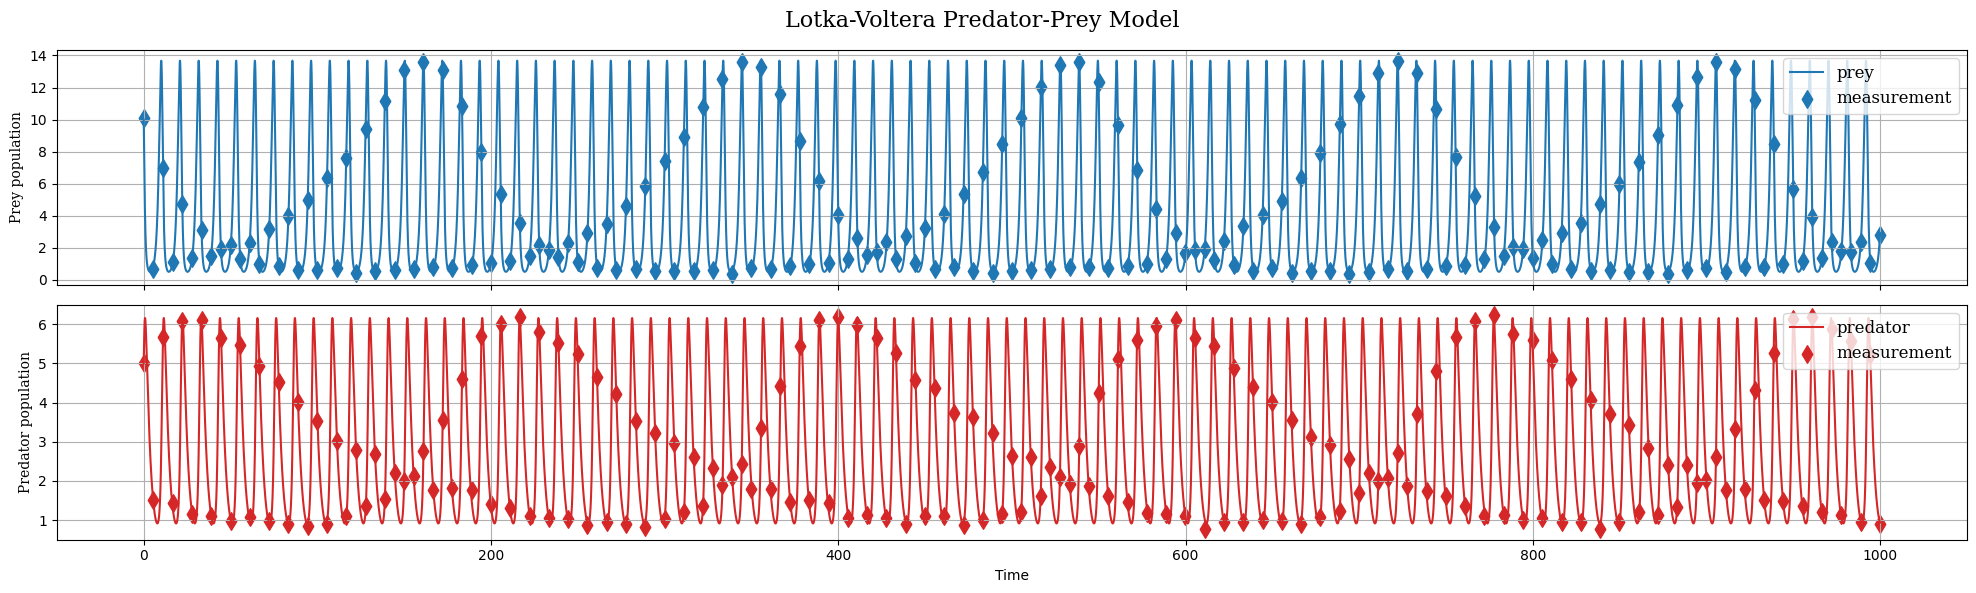

In [48]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="prey", c='tab:blue',)
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80)
ax1.set_ylabel("Prey population", fontname=fontname)
ax1.legend(loc='upper right',prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='tab:red', marker='d',s=80)
ax2.set_ylabel("Predator population", fontname=fontname)
ax2.set_xlabel("Time")
ax2.grid(True)
ax2.legend(loc='upper right',prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

$$\dot x = \alpha x - \beta x y$$
$$\dot y = -\gamma y + \delta x y $$

where $\alpha = 1.1$, $\beta = 0.4$, $\gamma  = 0.4$, and $\delta = 0.1$.

In [7]:
expdata.print(precision=1)

(x)' = 1.1 x + -0.4 x y
(y)' = -0.4 y + 0.1 x y


In [8]:
X = x_true[:,0]
t = t_true
dt = t[1]-t[0]

In [9]:
Y = fft(X-np.mean(X))
Y_real = np.real(Y)
Y_imag = np.imag(Y)
freqs = fftfreq(len(t),dt)
pos_mask = freqs > 0
power = np.abs(Y[pos_mask])**2

In [10]:
peaks, _ = find_peaks(power)

In [11]:
power[peaks]

array([4.86598283e+10, 1.01352275e+10, 3.40340499e+09, 5.76357403e+08,
       7.03968903e+07, 2.53784121e+07, 4.73639857e+06, 3.33171319e+04,
       5.47745675e+05, 1.34643782e+05, 2.58483730e+04, 1.60833869e+04,
       2.30661627e+04, 1.30452270e+04, 1.26799987e+04, 9.75807984e+03,
       9.38454750e+03, 8.78997841e+03, 7.96019397e+03, 7.05144659e+03,
       6.10925987e+03, 5.44248006e+03, 5.35738424e+03, 4.80752414e+03,
       4.77023371e+03, 4.27448786e+03, 3.84194901e+03])

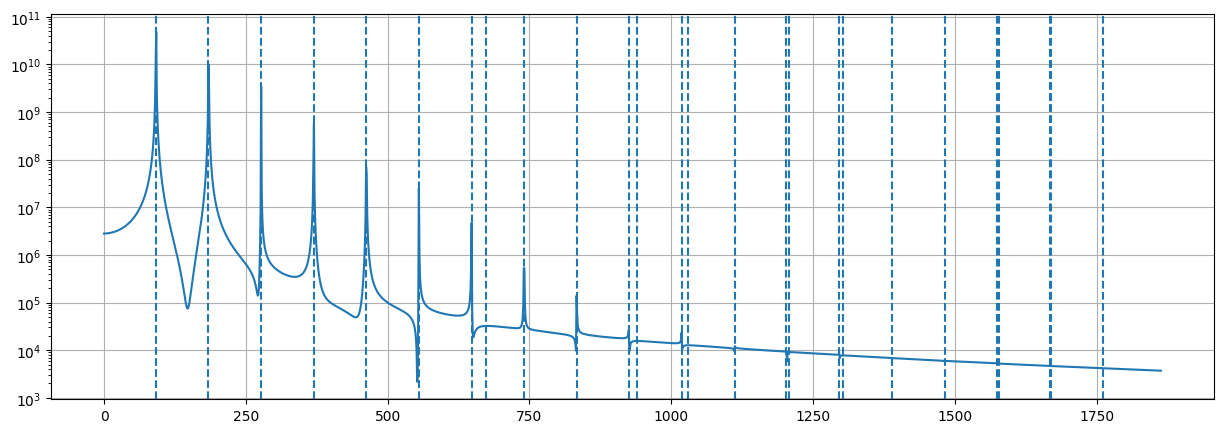

In [51]:
cutoff = -1
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(power[:peaks[cutoff]+10])
for peak in peaks[:cutoff]: 
    ax.axvline(peak, linestyle='--')
ax.grid(True)
ax.set_yscale('log')
plt.show()
# sampling slightly les than half the period

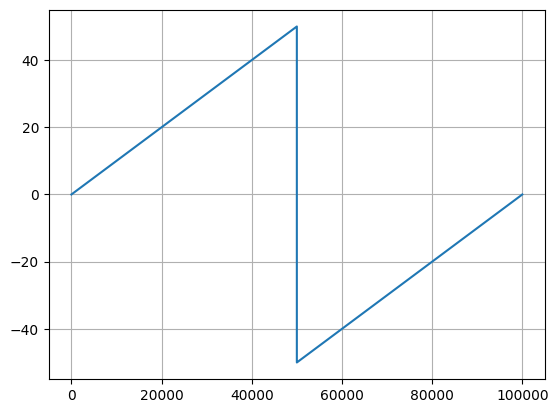

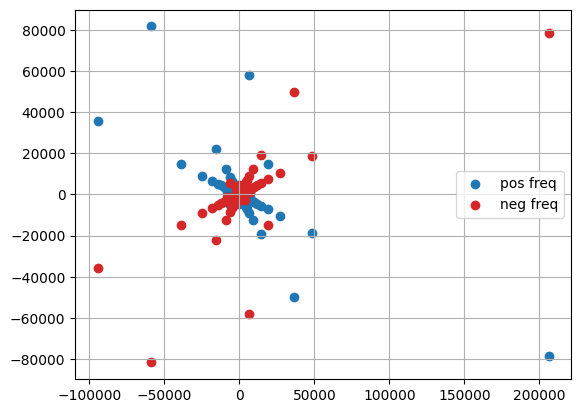

In [24]:
plt.plot(freqs)
plt.grid(True)
plt.show()
plt.scatter(Y_real[pos_mask],Y_imag[pos_mask],c='tab:blue', label='pos freq')
plt.scatter(Y_real[~pos_mask],Y_imag[~pos_mask],c='tab:red', label = 'neg freq')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

def get_nyquist_info(x, t, trim_start=0):
    # Trim initial time if needed
    mask = t > trim_start
    x = x[mask]
    t = t[mask]

    Y = fft(x - np.mean(x))
    dt = t[1] - t[0]
    freqs = fftfreq(len(t), dt)

    pos_mask = freqs > 0
    pos_freqs = freqs[pos_mask]
    power = np.abs(Y[pos_mask])**2

    f_max = pos_freqs[np.argmax(power)]
    nyquist_fs = 2 * f_max

    return f_max, nyquist_fs, power, pos_freqs


prey
Estimated dominant frequency: 0.093 Hz
Nyquist sampling frequency: 0.186 Hz
Sampling rate: 5.376 s
5.376290322580646
predator
Estimated dominant frequency: 0.093 Hz
Nyquist sampling frequency: 0.186 Hz
Sampling rate: 5.376 s


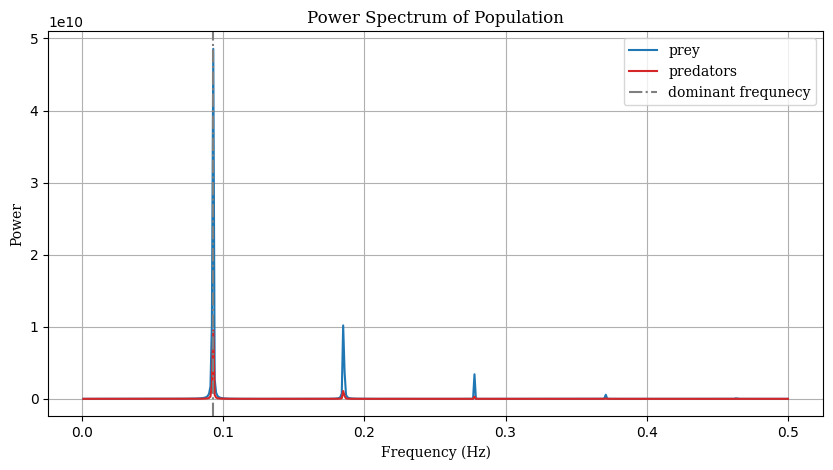

49999


In [30]:

# Assuming `sol` from earlier
# prey = x_true[:,0]
# t = t_true
# dt = t[1] - t[0]


f_max, nyquist_fs,power, pos_freqs = get_nyquist_info(x_true[:,0],t_true)
f_max2, nyquist_fs2,power2, pos_freqs2 = get_nyquist_info(x_true[:,1],t_true)

print("prey")
print(f"Estimated dominant frequency: {f_max:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs:.3f} s")
print(1/nyquist_fs)

print('predator')
print(f"Estimated dominant frequency: {f_max2:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs2:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs2:.3f} s")

# Optional: Plot spectrum
family = 'serif'

fig, ax1 = plt.subplots(1,1, figsize= (10,5))

tot = len(power)
tot=500
ax1.plot(pos_freqs[:tot], power[:tot], label='prey')
ax1.plot(pos_freqs2[:tot],power2[:tot], c='tab:red', label='predators')
ax1.axvline(f_max, linestyle='-.', c='grey', label='dominant frequnecy')
ax1.set_xlabel("Frequency (Hz)",family=family)
ax1.set_ylabel("Power", family=family)
ax1.set_title("Power Spectrum of Population", family=family)
ax1.legend(prop = {'family': family})
ax1.grid(True)


plt.show()
print(len(power))

# How is nyquist frequency changing over time

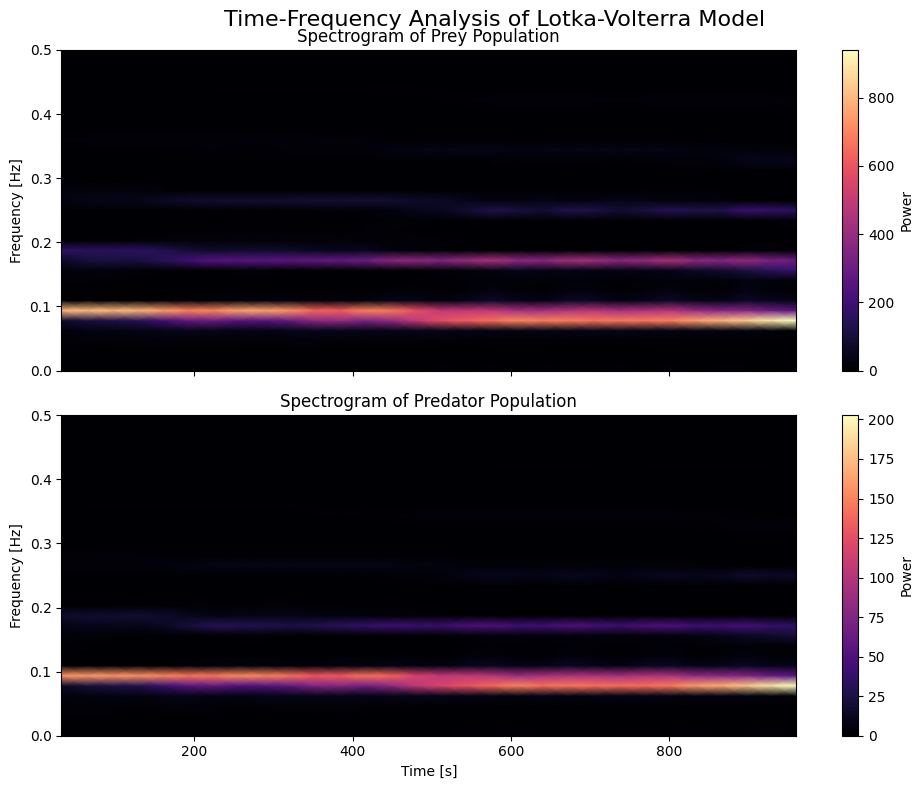

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram

# Lotka-Volterra parameters
alpha, beta, gamma, delta = 1.1, 0.4, 0.4, 0.1

def lotka_volterra(t, z):
    x, y = z
    return [alpha * x - beta * x * y, delta * x * y - gamma * y]

# Simulate system
x0, y0 = 10, 5
t_end = 1000
t_eval = np.linspace(0, t_end, 4000)
sol = solve_ivp(lotka_volterra, [0, t_end], [x0, y0], t_eval=t_eval)

prey = sol.y[0]
pred = sol.y[1]
t = sol.t
dt = t[1] - t[0]
fs = 1 / dt

# Compute spectrograms
f_prey, t_prey, Sxx_prey = spectrogram(prey, fs=fs, nperseg=256, noverlap=128)
f_pred, t_pred, Sxx_pred = spectrogram(pred, fs=fs, nperseg=256, noverlap=128)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

im1 = ax1.pcolormesh(t_prey, f_prey, Sxx_prey, shading='gouraud', cmap='magma')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_title('Spectrogram of Prey Population')
ax1.set_ylim(0, 0.5)
fig.colorbar(im1, ax=ax1, label='Power')

im2 = ax2.pcolormesh(t_pred, f_pred, Sxx_pred, shading='gouraud', cmap='magma')
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [s]')
ax2.set_title('Spectrogram of Predator Population')
ax2.set_ylim(0, 0.5)
fig.colorbar(im2, ax=ax2, label='Power')

plt.tight_layout()
plt.suptitle('Time-Frequency Analysis of Lotka-Volterra Model', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()


# Learn Model

In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel


In [34]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [35]:
from exp.evaluate.jsindy import evaluate_jmodel

In [36]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.47957969, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 10.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 559.4, gradnorm = 522.5, alpha = 4.167, improvement_ratio = 0.9815
Iteration 1, loss = 428.3, gradnorm = 993.2, alpha = 4.167, improvement_ratio = 0.6761
Iteration 2, loss = 356.4, gradnorm = 1.526e+03, alpha = 4.167, improvement_ratio = 0.5903
Iteration 3, loss = 304.2, gradnorm = 676.1, alpha = 4.167, improvement_ratio = 0.4004
Iteration 4, loss = 258.3, gradnorm = 1.154e+03, alpha = 4.167, improvement_ratio = 0.4102
Iteration 5, loss = 202.1, gradnorm = 618.7, alpha = 4.167, improvement_ratio = 0.5535
Iteration 200, loss = 0.01047, gradnorm = 0.001836, alpha = 3.566e-05, improvement_ratio = 0.7858
Iteration 255, loss = 0.01047, gradnorm = 9.203e-09, alpha = 1.271e-05, improvement_ratio = 0.8393
Model after smooth warm start
(x)' = -4.637 1 + 2.523 x + 0.789 y + -0.063 x^2 + -0.873 x y + 0.403 y^2
(y)' = -0.019 1 + -1.660 x + 4.041 y + 0.212 x^2 + -0.293 x y + -0.539 y^2
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized
(x)' = -15.801 

{'mse': Array(42.88453626, dtype=float64),
 'rmse': np.float64(6.548628578223963),
 'mae': np.float64(5.506477653357771),
 'max_abs_error': np.float64(13.69245675835986),
 'normalized_mse': Array(6.11079912, dtype=float64),
 'relative_l2_error': np.float64(2.4719975723251952)}

In [37]:
metrics["xdot_metrics"]

{'mse': Array(42.88453626, dtype=float64),
 'rmse': np.float64(6.548628578223963),
 'mae': np.float64(5.506477653357771),
 'max_abs_error': np.float64(13.69245675835986),
 'normalized_mse': Array(6.11079912, dtype=float64),
 'relative_l2_error': np.float64(2.4719975723251952)}

In [38]:
expdata.print()

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


In [39]:
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true

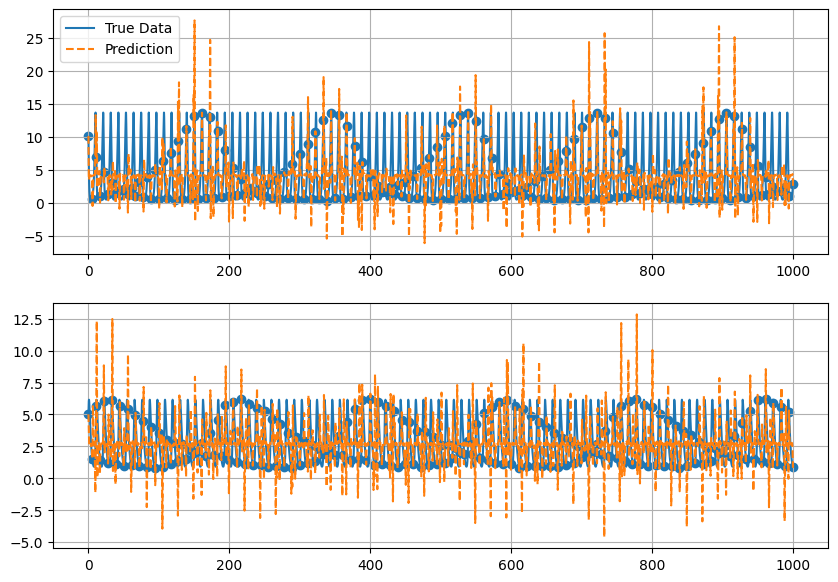

In [40]:
# for i in range(len(pred_sim.T)):
#     plt.scatter(t_train, x_train[:,i])
#     plt.plot(t_true, x_true[:,i], label='true')
#     # plt.plot(t_true, true[:,i])
#     plt.plot(t_true, pred_sim[:,i], label='pred', linestyle='--')
#     plt.legend()
#     plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,7))

for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx])
    ax[idx].plot(t_true, x_true[:,idx], label='True Data')
    ax[idx].plot(t_true, x_pred[:,idx], label='Prediction',linestyle='--')
    ax[idx].grid(True)
    if idx==0:
        ax[idx].legend()


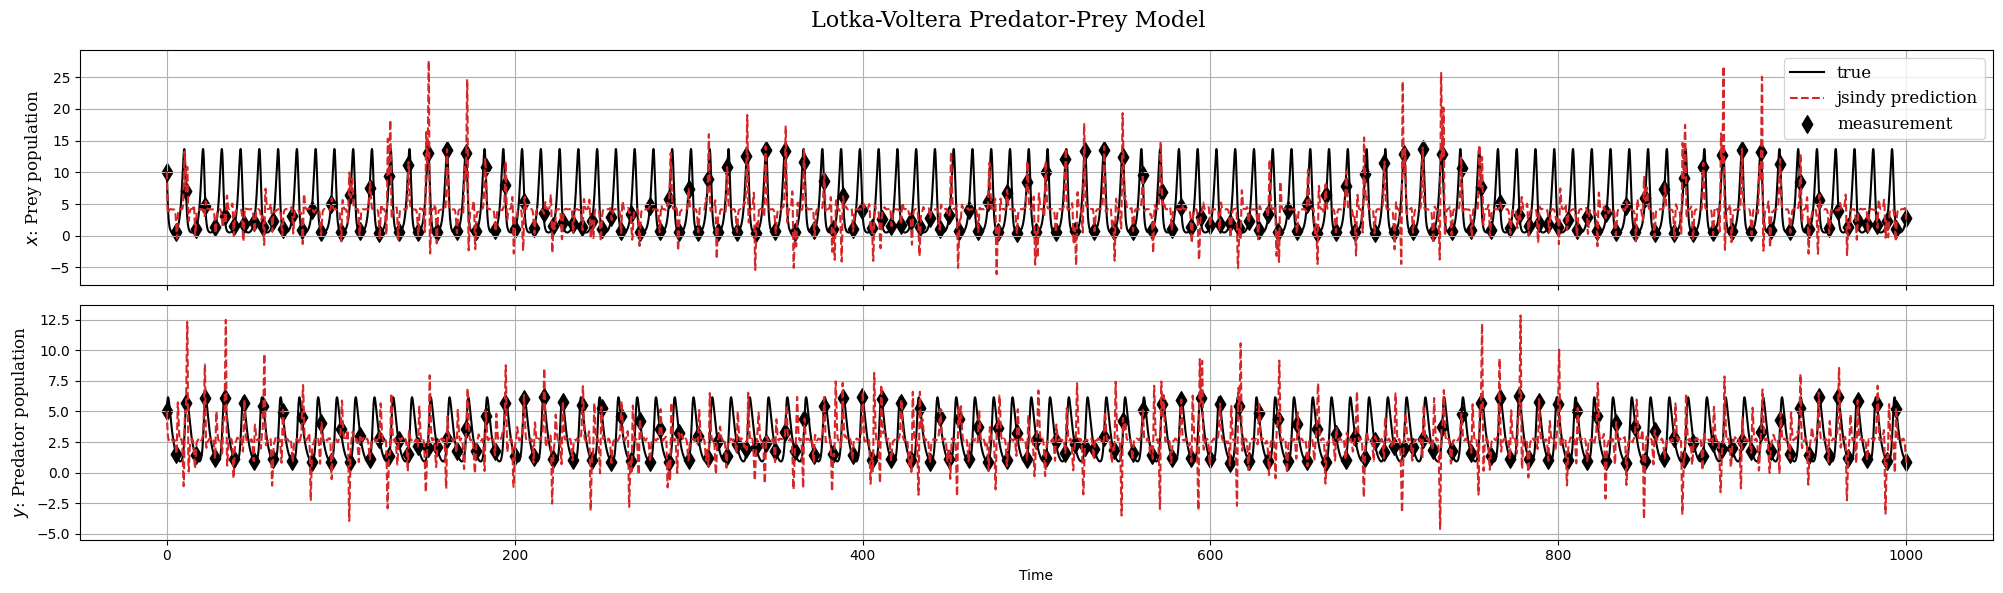

In [42]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Prey population", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, x_pred[:,1], label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$y$: Predator population", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

In [43]:
xdot_pred = model.predict(expdata.x_true)
xdot_true = expdata.x_dot

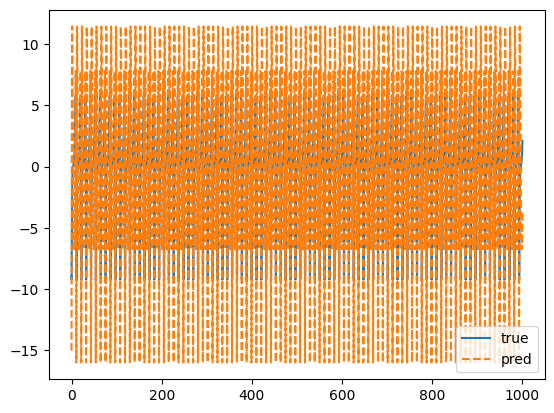

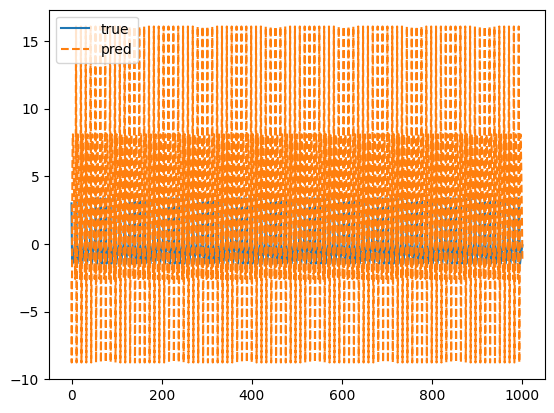

In [44]:
for i in range(len(xdot_pred.T)):
    plt.plot(t_true, xdot_true[:,i], label='true')
    plt.plot(t_true, xdot_pred[:,i], label='pred', linestyle='--')
    plt.legend()
    plt.show()

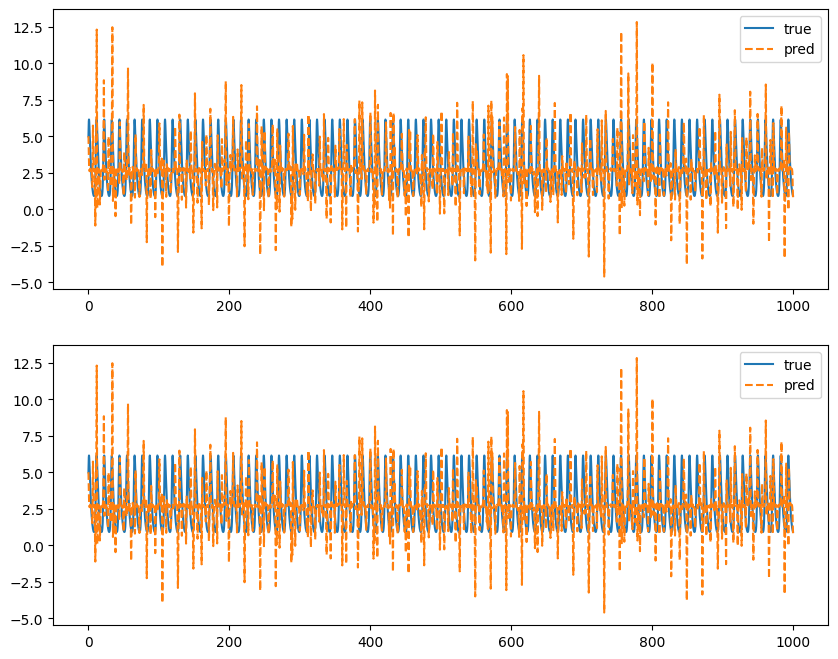

In [45]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

for idx in range(2):
    # ax[idx].scatter(t_train, x_train[:,idx])
    ax[idx].plot(t_true, x_true[:,i], label='true')
    # plt.plot(t_true, true[:,i])
    ax[idx].plot(t_true, x_pred[:,i], label='pred', linestyle='--')
    ax[idx].legend()



In [46]:
import jax
from equinox import tree_pprint
tree_pprint(model.traj_model.kernel, short_arrays=False)
k1 = model.traj_model.kernel.kernels[1]


SumKernel(
  kernels=(
    ConstantKernel(raw_variance=Array(11.61045001, dtype=float64)),
    ScalarMaternKernel(
      core_matern=<function build_matern_core.<locals>.<lambda>>,
      p_order=5,
      raw_variance=Array(9.72067194, dtype=float64),
      raw_lengthscale=Array(-0.57656801, dtype=float64),
      min_lengthscale=0.01
    )
  )
)


In [47]:
jax.nn.softplus(k1.raw_lengthscale) + k1.min_lengthscale


Array(0.45585388, dtype=float64)

# Try Annealed Optimizer

In [28]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier,
        num_annealing_steps=4,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [29]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.12681487, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 10.0}
Solving for data_weight = 20.0, colloc_weight = 0.08 beta_reg = 8e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.1447, gradnorm = 16.6, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.1414, gradnorm = 0.7332, alpha = 3.472, improvement_ratio = 0.9998
Iteration 2, loss = 0.1407, gradnorm = 0.06144, alpha = 2.894, improvement_ratio = 0.9983
Iteration 3, loss = 0.1402, gradnorm = 0.04432, alpha = 2.411, improvement_ratio = 0.9988
Iteration 4, loss = 0.1395, gradnorm = 0.04028, alpha = 2.009, improvement_ratio = 0.9994
Iteration 5, loss = 0.1388, gradnorm = 0.0389, alpha = 1.674, improvement_ratio = 0.9998
Iteration 90, loss = 0.0009091, gradnorm = 8.18e-09, alpha = 1.555e-05, improvement_ratio = 0.235
Solving for data_weight = 20.0, colloc_weight = 0.4 beta_reg = 4e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.001258, gradnorm = 0.003216, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.001258, gradnorm = 0.000469, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.001258, gradnorm = 0.0004451, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.001257, gradnorm = 0.0004435, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.001257, gradnorm = 0.0004416, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.001257, gradnorm = 0.0004395, alpha = 1.674, improvement_ratio = 1.0
Iteration 86, loss = 0.001165, gradnorm = 5.099e-09, alpha = 6.56e-05, improvement_ratio = 0.6456
Solving for data_weight = 20.0, colloc_weight = 2.0 beta_reg = 2e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.002144, gradnorm = 0.01109, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.002144, gradnorm = 0.0006889, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.002144, gradnorm = 0.0004704, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.002144, gradnorm = 0.000464, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.002144, gradnorm = 0.0004574, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.002144, gradnorm = 0.0004502, alpha = 1.674, improvement_ratio = 1.0
Iteration 186, loss = 0.001635, gradnorm = 3.481e-09, alpha = 0.0006757, improvement_ratio = 21.41
Solving for data_weight = 20.0, colloc_weight = 10.0 beta_reg = 1e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.00276, gradnorm = 0.0254, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.00276, gradnorm = 0.001285, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.00276, gradnorm = 0.0005885, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.00276, gradnorm = 0.0005691, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.00276, gradnorm = 0.0005535, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.002759, gradnorm = 0.0005392, alpha = 1.674, improvement_ratio = 1.0
Iteration 132, loss = 0.001943, gradnorm = 7.787e-09, alpha = 0.0005091, improvement_ratio = 10.78
Model after smooth warm start
(x)' = -0.023 1 + -0.646 x + -0.155 y + -0.005 x^2 + 0.243 x y + 0.038 y^2
(y)' = 0.902 1 + -0.212 x + -0.003 y + 0.002 x^2 + -0.084 x y + 0.033 y^2
Alternating Activeset Sparsifier
4 active coeffs changed
Active set stabilized
(x)' = -0.800 x + 0.257 x y
(y)' = 1.301 1 + -0.458 x


{'mse': Array(22.18303566, dtype=float64),
 'rmse': np.float64(4.709887010891454),
 'mae': np.float64(3.2775230764635883),
 'max_abs_error': np.float64(14.316294396085361),
 'normalized_mse': Array(3.10176563, dtype=float64),
 'relative_l2_error': np.float64(1.760819567573138)}

In [32]:
expdata.print()
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


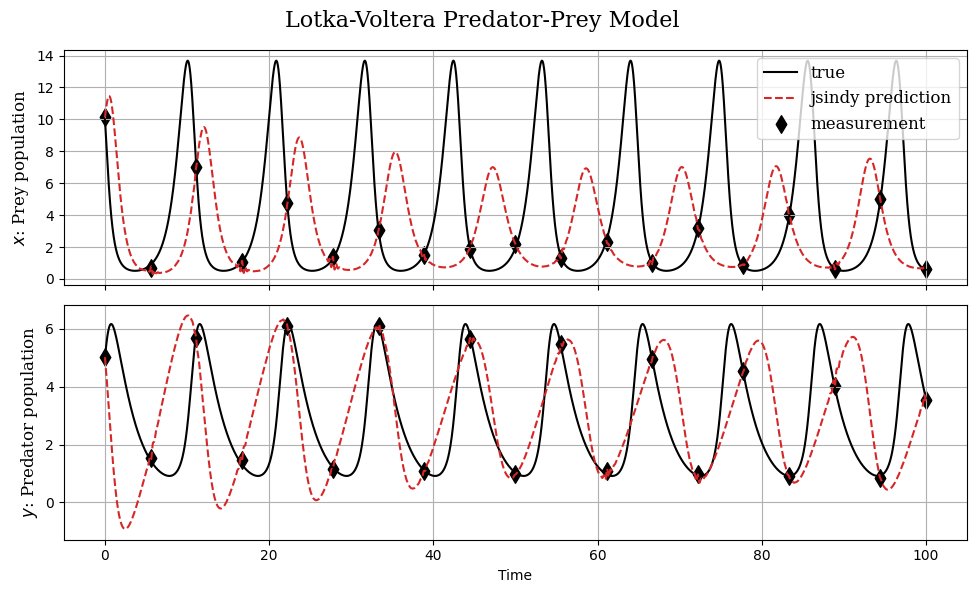

In [33]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Prey population", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, x_pred[:,1], label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$y$: Predator population", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

# E-SINDy

In [24]:
import pysindy as ps

In [25]:
t_train[-1]+dt_train

Array(105.545, dtype=float64)